In [1]:
import pandas as pd
import re
from pathlib import Path
import pyarabic.araby as ar
from tqdm.notebook import tqdm
from sklearn.utils import shuffle
import pickle as pkl
import os
from tensorflow.keras.models import load_model

In [2]:
class Config:
    raw_data_file = 'tweets.csv'
    processed_data_file = 'tweets.csv'
    
    RAW_DATA_PATH = Path('../../data/raw')
    PROCESSED_DATA_PATH = Path('../../data/processed')
    
    RAW_DATA_FILE = RAW_DATA_PATH / raw_data_file
    PROCESSED_DATA_FILE = PROCESSED_DATA_PATH / processed_data_file
    
    MODEL_PATH = Path('../../model/lyrics')
    
    AROUSAL_MODEL_PATH = Path('../../model/music/arousal_model.h5')
    VALENCE_MODEL_PATH = Path('../../model/music/valence_model.h5')
    
    PLOT_PATH = Path('../../plots')
    PLOT_HEAT_MAP_FILE = PLOT_PATH / Path('heatmap.png')

In [3]:
SEED = 42

In [4]:
processed_data = pd.read_csv(Config.PROCESSED_DATA_FILE, index_col=False)

In [5]:
processed_data.head()

,ID,Tweet,Class
0,295820374774513667,رودجرز انا مستاء من لاعبينا الشباب حولنا منحهم...,anger
1,353619287652581376,من شفت انا عيونه اعلنت انا جنوني,anger
2,888346524714979329,أتفق انا عصبي وقاسي وعنيد ومتناقض ومزاجي وكتوم...,anger
3,870974517983752193,على فكرة انا مستاء جدا من تجربتي في محلكم في ا...,anger
4,886636321342619653,ع قد ما انا عصبي ع قد ما ابسط كلمه حلوه هتنسين...,anger


In [6]:
data = processed_data[processed_data['Class'].apply(lambda Class: Class in ['happiness', 'sadness', 'anger'])]
data = shuffle(data, random_state=SEED)
data.reset_index(drop=True, inplace=True)

In [7]:
data.head()

,ID,Tweet,Class
0,399179057843019776,والله انا فرحان انى مش هكتب بعد الماتش سنظل او...,happiness
1,166914704663515137,هممم اسأل نفسك هل قدمت وجبة لشخص محتاج او حيوا...,happiness
2,873773656693977088,انا حزين علي نفسي و علي الي وصلتله ده فكل حاجه...,sadness
3,696635298046943232,بيتوركا عبر المؤتمر الصحفي انا فرحان ان الجمهو...,happiness
4,201996771512164352,مسآئي مختلف هذا اليوم مذ ان رأيتك شعرت براحةة ...,happiness


In [8]:
data['Class'].value_counts()

happiness    22788
sadness      12906
anger         1154
Name: Class, dtype: int64

In [9]:
import tensorflow as tf
import tensorflow_addons as tfa

In [10]:
physical_devices = tf.config.list_physical_devices("GPU")

In [11]:
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [12]:
from sklearn.model_selection import train_test_split
import numpy as np

In [13]:
X = np.array(list(data['Tweet'])).astype(str)
y = np.array(list(data['Class'])).astype(str)

In [14]:
X.dtype

dtype('<U140')

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=SEED)

In [16]:
from sklearn.preprocessing import LabelEncoder

In [17]:
label_encoder = LabelEncoder()

In [18]:
label_encoder.fit(y_train)

LabelEncoder()

In [19]:
label_encoder.classes_

array(['anger', 'happiness', 'sadness'], dtype='<U9')

In [20]:
class_num = len(label_encoder.classes_)

In [21]:
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

In [22]:
y_train = tf.keras.utils.to_categorical(y_train, class_num)
y_test = tf.keras.utils.to_categorical(y_test, class_num)

In [23]:
VOCAB_SIZE = 10000

In [24]:
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE
)

In [25]:
encoder.adapt(X_train)

In [26]:
encoder

In [27]:
encoder.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'max_tokens': 10000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': None,
 'pad_to_max_tokens': True}

In [28]:
with open('text_vectorizer.pkl', 'wb') as file:
    pkl.dump({
        'config': encoder.get_config(),
         'weights': encoder.get_weights()
    }, file)

In [29]:
# with open('text_vectorizer.pkl', 'rb') as file:
#     from_disk = pkl.load(file)
#     encoder = tf.keras.layers.experimental.preprocessing.TextVectorization.from_config(from_disk['config'])
#     encoder.set_weights(from_disk['weights'])

In [30]:
vocab = np.array(encoder.get_vocabulary())

In [31]:
vocab[0].decode('UTF-8')

'انا'

In [32]:
vocab = np.array(encoder.get_vocabulary())

In [33]:
vocab_utf8 = [word.decode('UTF-8') for word in vocab]

In [34]:
# vocab_utf8

In [35]:
tf.keras.backend.clear_session()

In [36]:
def create_model():
    model = tf.keras.Sequential()
    
    model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
    
    model.add(encoder)
    
    model.add(
        tf.keras.layers.Embedding(
        input_dim=VOCAB_SIZE+1,
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True,
        name="embedding_layer")
    )
    
    model.add(
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64), name="bi_lstm_layer")
    )
    
    model.add(
        tf.keras.layers.Dense(64, activation='relu', name="dense_layer")
    )
    
    model.add(
        tf.keras.layers.Dense(class_num, 'softmax', name="output_layer")
    )
    return model

In [37]:
model = create_model()

In [38]:
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=[tfa.metrics.F1Score(class_num)]
)

In [39]:
X_train.shape

(24688,)

In [40]:
y_train.shape

(24688, 3)

In [41]:
checkpoint_path = str(Config.MODEL_PATH /  "cp-{epoch:04d}.ckpt")
checkpoint_dir = os.path.dirname(checkpoint_path)

In [42]:
model_check_point_cb = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                   monitor='val_f1_score',
                                                   save_weights_only=True)

In [43]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[model_check_point_cb])

Train on 19750 samples, validate on 4938 samples
Epoch 1/20
19750/19750 [==============================] - 30s 2ms/sample - loss: 0.5436 - f1_score: 0.5071 - val_loss: 0.1436 - val_f1_score: 0.6483
Epoch 2/20
19750/19750 [==============================] - 17s 884us/sample - loss: 0.0960 - f1_score: 0.6580 - val_loss: 0.0769 - val_f1_score: 0.7391
Epoch 3/20
19750/19750 [==============================] - 17s 875us/sample - loss: 0.0495 - f1_score: 0.8784 - val_loss: 0.0608 - val_f1_score: 0.9103
Epoch 4/20
19750/19750 [==============================] - 16s 831us/sample - loss: 0.0261 - f1_score: 0.9790 - val_loss: 0.0468 - val_f1_score: 0.9652
Epoch 5/20
19750/19750 [==============================] - 16s 832us/sample - loss: 0.0137 - f1_score: 0.9927 - val_loss: 0.0470 - val_f1_score: 0.9737
Epoch 6/20
19750/19750 [==============================] - 16s 835us/sample - loss: 0.0068 - f1_score: 0.9972 - val_loss: 0.0485 - val_f1_score: 0.9743
Epoch 7/20
19750/19750 [=======================

In [47]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [48]:
model.load_weights(checkpoint_path.format(epoch=13))

In [49]:
def evaluate(model):
    Config.PLOT_PATH.mkdir(parents=True, exist_ok=True)
    predictions = model.predict(X_test)
    
    y_pred = predictions.argmax(axis=1)
    y_true = y_test.argmax(axis=1)
    
    report = classification_report(y_true, y_pred, output_dict=True, target_names=label_encoder.classes_)
    df = pd.DataFrame(report).transpose()
    
    plt.title('Classification Report')
    plt.legend([])
    sns.heatmap(df, annot=True, vmin=0, vmax=1, linewidths=.5)
    plt.savefig(str(Config.PLOT_HEAT_MAP_FILE))
    plt.show()
    plt.clf()

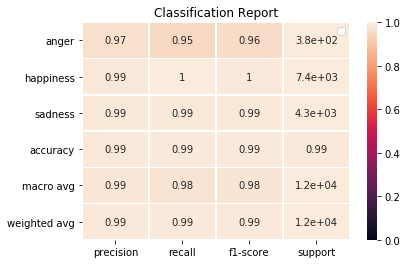

<Figure size 432x288 with 0 Axes>

In [50]:
evaluate(model)

In [55]:
# with open('example/happy.txt', 'r', encoding='utf-8') as file:
#     text = file.read()

In [56]:
text = ""

'يا اطبطب وادلع يا يقولي أنا اتغيرت عليه أنا ازعل أولع ما هو كل همه إزاي أرضيه يا اطبطب وادلع يا يقولي أنا اتغيرت عليه أنا ازعل أولع ما هو كل همه إزاي أرضيه قولوله ده أنا برده ساعات بحالات مرة أزعل مرة أديله عيني مين فينا على حاله كل الأوقات ده تاعبني أوي طلع عيني قولوله ده أنا برده ساعات بحالات مرة أزعل مرة أديله عيني مين فينا على حاله كل الأوقات ده تاعبني أوي طلع عيني اطبطب وادلع يا يقولي أنا اتغيرت عليه أنا ازعل أولع ما هو كل همه إزاي أرضيه لو أزعل منه واقصر يقول بقصر في حقه وياخد جنب ولو أفهمه يقول بظلمه يفضل يحسسني بـ ١٠٠ ذنب لو أزعل منه واقصر يقول بقصر في حقه وياخد جنب ولو أفهمه يقول بظلمه يفضل يحسسني بـ ١٠٠ ذنب قولوله ده أنا برده ساعات بحالات مرة أزعل مرة أديله عيني مين فينا على حاله كل الأوقات ده تاعبني أوي طلع عيني قولوله ده أنا برده ساعات بحالات مرة أزعل مرة أديله عيني مين فينا على حاله كل الأوقات تاعبني أوي طلع عيني اطبطب وادلع يا يقولي أنا اتغيرت عليه أنا ازعل أولع ما هو كل همه إزاي أرضيه قال أنا بتغير ولا ده عقله صغير حير قلبي معاه وحكم القوي بموت فيه أوي وده اللي صبرني عل

In [57]:
def classify_emotion(text):
    angry, happy, sad = model.predict([text])[0]
    print(f'angry = {angry * 100}%')
    print(f'happy = {happy * 100}%')
    print(f'sad = {sad * 100}%')

In [58]:
classify_emotion(text)

angry = 12.18971461057663%
happy = 0.05356245092116296%
sad = 87.75672316551208%


In [71]:
arousal_model = load_model(Config.AROUSAL_MODEL_PATH)

In [72]:
arousal_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6373)]            0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 50992     
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 51,033
Trainable params: 51,033
Non-trainable params: 0
_________________________________________________________________


In [73]:
valence_model = load_model(Config.VALENCE_MODEL_PATH)

In [74]:
valence_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6373)]            0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 50992     
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 51,033
Trainable params: 51,033
Non-trainable params: 0
_________________________________________________________________


In [176]:
arousal_model.layers[0]._name = "arousal_input"
valence_model.layers[0]._name = "valence_input"
model.layers[0]._name = "lyrics_input"

In [184]:
arousal_model.layers[1]._name = "arousal_dense_1"
arousal_model.layers[2]._name = "arousal_dense_2"

In [185]:
valence_model.layers[1]._name = "valence_dense_1"
valence_model.layers[2]._name = "valence_dense_2"

In [186]:
arousal_input = arousal_model.layers[0].input
valence_input = valence_model.layers[0].input

In [187]:
arousal_output = arousal_model.layers[-2].output
valence_output = valence_model.layers[-2].output

In [188]:
lyrics_input = model.layers[0].input

In [189]:
lyrics_output = model.layers[-2].output

In [190]:
concat_layer = tf.keras.layers.Concatenate(name="concat_layer")([lyrics_output, arousal_output, valence_output])

In [191]:
output = tf.keras.layers.Dense(class_num, activation='softmax', name="output_layer")(concat_layer)

In [192]:
final_model = tf.keras.Model(inputs=[lyrics_input, arousal_input, valence_input], outputs=output)